In [27]:
import tensorflow as tf
import time

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

In [1]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [2]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
#         self.parser = spacy.load('en_vectors_web_lg')
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [3]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [4]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [5]:
reviews = list(ImdbMovieReviews())

In [6]:
random.shuffle(reviews)

In [7]:
#################################################

In [8]:
import HanSequenceLabellingModel, model_components

In [9]:
# %load_ext autoreload
# %autoreload 1
# %aimport HanSequenceLabellingModel, model_components
# %aimport

In [10]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [11]:
import importlib
importlib.reload(HanSequenceLabellingModel)
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [12]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints_old'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())

    return model, saver

In [13]:
max_iters = 2000

In [14]:
do_train = False
if do_train:
    tf.reset_default_graph()

    config = tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True)

    with tf.Session(config=config) as s:
        model, saver = HAN_model_1(s)
        tflog_dir = 'tf_logs'
        summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

        for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc,_) in enumerate(batches_split):

            fd = {
                model.is_training: True,
                model.inputs_embedded: data,
                model.word_lengths: words_per_sent_per_doc,
                model.sentence_lengths: sent_per_doc,
                model.labels: labels_batch,
                model.sample_weights: np.ones(shape=(10))
            }

            t0 = time.clock()
            step, summaries, loss, accuracy, _ = s.run([
                    model.global_step,
                    model.summary,
                    model.loss,
                    model.accuracy,
                    model.train_op,
            ], feed_dict=fd)
            td = time.clock() - t0

            summary_writer.add_summary(summaries, global_step=step)

            checkpoint_frequency = 100
            eval_frequency = 1

            if i >= max_iters:
                break

            if step % 1 == 0:
                print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape), end='\r')
            if step != 0 and step % checkpoint_frequency == 0:
    #             print('checkpoint & graph meta')
                checkpoint_path = 'checkpoints/checkpoint'
                saver.save(s, checkpoint_path, global_step=step)
    #             print('checkpoint done')

In [15]:
#copied from https://gist.github.com/christian-oudard/220521

# System color name constants.
(
    BLACK,
    RED,
    GREEN,
    YELLOW,
    BLUE,
    MAGENTA,
    CYAN,
    LIGHT_GRAY,
    DARK_GRAY,
    BRIGHT_RED,
    BRIGHT_GREEN,
    BRIGHT_YELLOW,
    BRIGHT_BLUE,
    BRIGHT_MAGENTA,
    BRIGHT_CYAN,
    WHITE,
) = range(16)

def rgb(red, green, blue):
    """
    Calculate the palette index of a color in the 6x6x6 color cube.
    The red, green and blue arguments may range from 0 to 5.
    """
    return 16 + (red * 36) + (green * 6) + blue

def gray(value):
    """
    Calculate the palette index of a color in the grayscale ramp.
    The value argument may range from 0 to 23.
    """
    return 232 + value

def set_color(fg=None, bg=None):
    """
    Print escape codes to set the terminal color.
    fg and bg are indices into the color palette for the foreground and
    background colors.
    """
    print(_set_color(fg, bg), end='')

def _set_color(fg=None, bg=None):
    result = ''
    if fg:
        result += '\x1b[38;5;%dm' % fg
    if bg:
        result += '\x1b[48;5;%dm' % bg
    return result

def reset_color():
    """
    Reset terminal color to default.
    """
    print(_reset_color(), end='')

def _reset_color():
    return '\x1b[0m'

def print_color(*args, **kwargs):
    """
    Print function, with extra arguments fg and bg to set colors.
    """
    fg = kwargs.pop('fg', None)
    bg = kwargs.pop('bg', None)
    set_color(fg, bg)
    print(*args, **kwargs)
    reset_color()


In [18]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    data, labels_batch, sent_per_doc,\
    words_per_sent_per_doc, sents_batch = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }

    word_attentions, sentence_att = s.run([model.word_attentions, 
                                              model.sentence_attentions], 
                                             feed_dict=fd)
    
    sent_atts = sentence_att[0]
    sents = sents_batch[0]
    
    max_sent_att = 0
    max_word_att = 0
    
    for sent_index in range(len(sents)):
        max_sent_att = max(max_sent_att, sent_atts[sent_index])
        
        for word_index in range(len(sents[sent_index])):
            max_word_att = max(max_word_att, word_attentions[sent_index][word_index])
            
    def draw_highlighted_att(max_sent_att_loc, max_word_att_loc):
        for sent_index in range(len(sents)):
            for word_index in range(len(sents[sent_index])):
                intensity = 5 - int(word_attentions[sent_index][word_index] / max_word_att_loc*5)
                print_color(sents[sent_index][word_index], bg=rgb(5, 0, intensity), end=' ') 
            print()
    
    draw_highlighted_att(max_sent_att, max_word_att)
    print()
    draw_highlighted_att(1.0, 1.0)

Reading model parameters from checkpoints_old/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints_old/checkpoint-2400
this movie has one redeeming feature 
at one point , after a character is attacked by an ax wielding fairy , his brother asks him , why is your dick over there , chuck ? after suffering through almost an hour of bad film , this almost made my drink come out my nose 
br br some of the acting isn t too bad , but the kids all stink and p 
j 
soles should be ashamed of herself for doing this film 
the story is weak and nobody does what you think ( or what common sense dictates ) they should 
br br of course , there are a lot of story points that don t add up 
for example , in one scene the ghosts of young children must concentrate hard to move a physical object so they can prove they exist , a difficult feat since they apparently can t interact with physical matter 
however , minutes later they all pick up branches off the ground and beat the tooth fairy w

a few nice boobs 
but this doesn t make up for the deficiencies 
br br if you want a movie about the tooth fairy , go rent darkness falls 
i think it s great , though a lot of other reviewers don t share my opinion 
at least it sets a mood 


In [25]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

good_true = list()
good_false = list()
bad_false = list()
bad_true = list()

#well, sometimes there is no enought gpu memory
with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        model, saver = HAN_model_1(sess, True)

        for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in tqdm.tqdm_notebook(enumerate(batches_split), total=max_iters):
            fd = {
                model.is_training: True,
                model.inputs_embedded: data,
                model.word_lengths: words_per_sent_per_doc,
                model.sentence_lengths: sent_per_doc,
                model.labels: labels_batch,
                model.sample_weights: np.ones(shape=(10))
            }

            words, sentences = sess.run([model.word_attentions, model.sentence_attentions], feed_dict=fd)

            for bt in range(len(sents_b)):
                for sent_num in range(len(sents_b[bt])):
                    for g in range(len(sents_b[bt][sent_num])):
                        val = words[bt * len(sentences[0]) + sent_num][g]
                        if (sents_b[bt][sent_num][g] == 'good'):
                            if labels_batch[bt] == True:
                                good_true.append(val)
                            else:
                                good_false.append(val)

                        if (sents_b[bt][sent_num][g] == 'bad'):
                            if labels_batch[bt] == True:
                                bad_true.append(val)
                            else:
                                bad_false.append(val)

            if (i >= max_iters):
                break

Reading model parameters from checkpoints_old/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints_old/checkpoint-2400


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


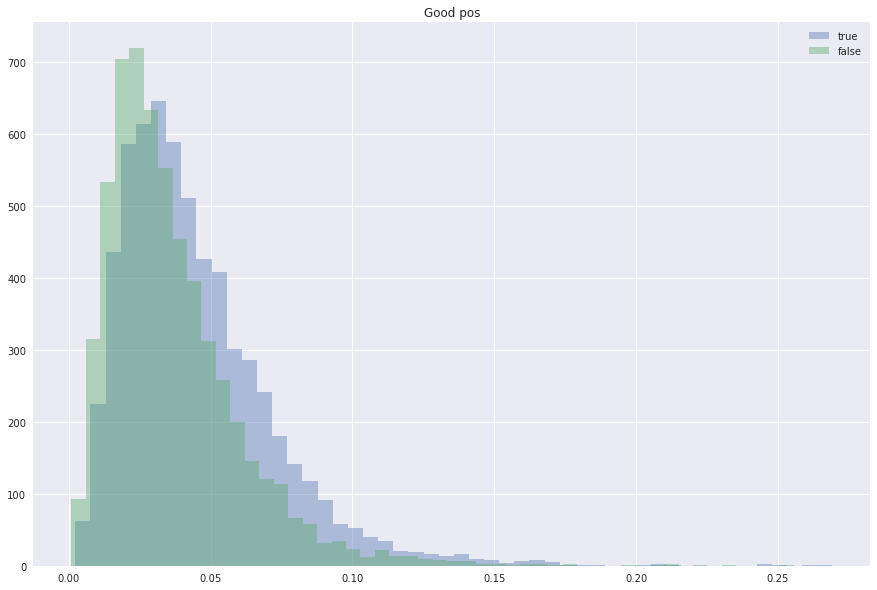

In [31]:
plt.figure(figsize=(15,10))
sns.distplot(good_true, kde=False, label='true')
sns.distplot(good_false, kde=False, label='false')

plt.legend()
plt.title('Good pos')

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


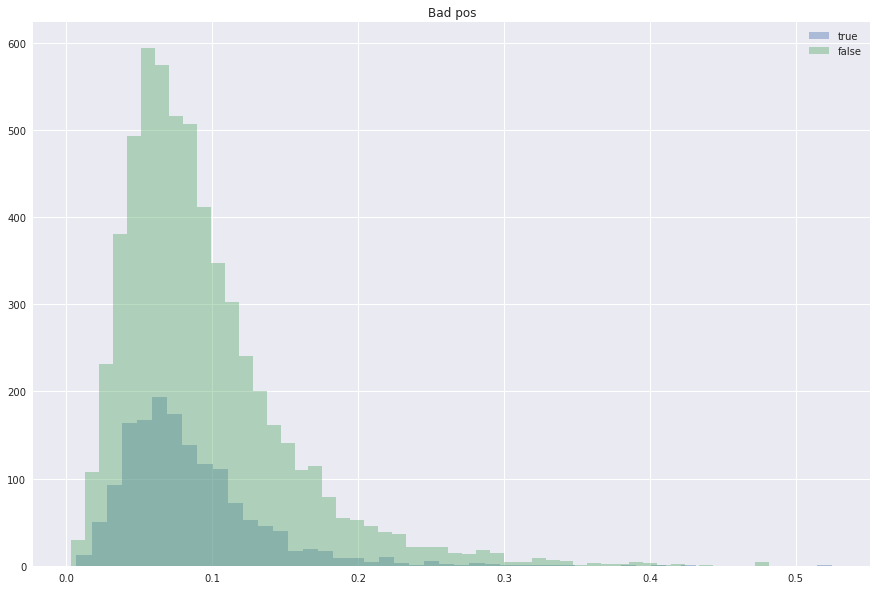

In [32]:
plt.figure(figsize=(15,10))
sns.distplot(bad_true, kde=False, label='true')
sns.distplot(bad_false, kde=False, label='false')

plt.legend()
plt.title('Bad pos')